In [1]:
import sys
sys.path.append("..")

import src.planner.rrt.decision as grrt

import json
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import sys
sys.path.append("../spring")
from src.planner.common import RoadSegment, CurrentState, Obstacle
from src.planner.predictor import ObstaclePredictor

In [2]:
# data load methods
with open("/home/elew/graic22dc/control_signals.txt", "r") as fp:
    #traces = json.load(fp)
    s = fp.read()

#s = f"[{s[:-1]}]"
traces = json.loads(s)

In [3]:
from matplotlib.collections import EllipseCollection

def plot_scenario(ax, cs, pred, vr, pr, goal, wp, title="Vehicle Decision Input"):
    lane_locs = cs.road.locations
    *bounds, cstatus = cs.road.get_bounds_segment(-1.0, 3.0, wp)
    if not cstatus:
        bounds = list(cs.road.bounds)
        bounds[0] = bounds[0][:, :2]
        bounds[1] = bounds[1][:, :2]
    center_line = (bounds[0] + bounds[1])/2.0
    waypoint = (((bounds[0] + bounds[1])/2.0)[-1, :2])

    state = cs.cpos
    velocity = cs.cvelocity

    # vehicle relevant stuff
    ax.arrow(*state, *np.array(velocity)/4, width=0.2, zorder=1000, label='ego vehicle velocity')
    ax.scatter(*state, marker='x', s=100, label='ego vehicle position')
    if goal is not None:
        ax.scatter(*goal[:2], marker='x', s=100, label='waypoint')
    
    # plot lane
    ax.plot(*lane_locs[0][:, :2].T, '-b', label='right lane marker')
    ax.plot(*lane_locs[1][:, :2].T, '-r', label='center lane marker')
    ax.plot(*lane_locs[2][:, :2].T, '-k')

    # plot road markers
    ax.plot(*bounds[0][:, :2].T, '-k', label='left road marker')
    ax.plot(*bounds[1][:, :2].T, '-k', label='right road marker')
    ax.plot(*center_line[:, :2].T, '-k', label='right road marker')
    ax.scatter(*wp[:2],  label='waypoint')
    
    # plot verts
    verts = pred.get_verts(state, vehicle_radius=vr, person_radius=pr)
    if len(verts) > 0:
        x, y = verts[:, :2].T
        size = verts[:, 2]
        offsets = list(zip(x, y))
        ax.add_collection(EllipseCollection(widths=size, heights=size, angles=0, units='xy',
                                       facecolors='r',
                                       offsets=offsets, transOffset=ax.transData))

    ax.grid()
    ax.axis('equal')
    ax.set_title(title)

generating new path
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
generating new path
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
generating new path
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
generating new path
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667
4.666666666666667


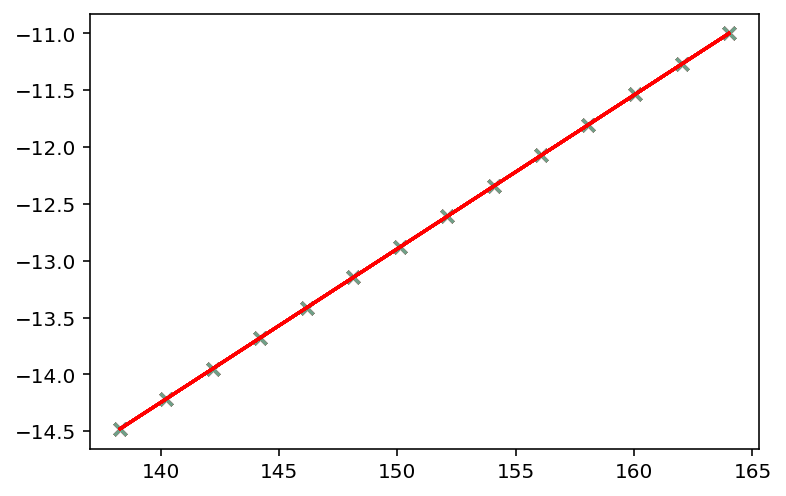

In [4]:
dec = grrt.RRTStarDecision(path_resolution=0.25, 
                           expand_dis=0.25, 
                           connect_circle_dist=5.0, 
                           goal_sample_rate=60, 
                           max_iter=400,
                           lanes_radius=1.5,
                          vehicle_radius=2.0)
crecord = traces[0]
for i in range(40):
    cs = CurrentState.from_dict(crecord)
    p, _, _ = dec.get_path(cs)
    plt.plot(*np.array(p).T, 'r', alpha=0.4)
    plt.scatter(*np.array(p).T, marker='x', alpha=0.4)
    print(len(p)/3)

In [5]:
def get_lanes(cs):
    leftb, rightb, cstatus = cs.road.get_bounds_segment(-0.25, 3.0)
    if not cstatus:
        bounds = cs.road.bounds
        leftb = bounds[0][:, :2]
        rightb = bounds[1][:, :2]
    centerb = (leftb + rightb) / 2.0
    return rightb, centerb, leftb

generating new path
rejecting waypoint
rejecting waypoint
rejecting waypoint
rejecting waypoint
rejecting waypoint
generating new path
rejecting waypoint
rejecting waypoint
rejecting waypoint
delete 92 walker.pedestrian.0020
rejecting waypoint
rejecting waypoint
generating new path
rejecting waypoint
rejecting waypoint
delete 94 vehicle.audi.a2
delete 95 vehicle.audi.a2
generating new path
generating new path
generating new path
delete 97 vehicle.tesla.model3
generating new path


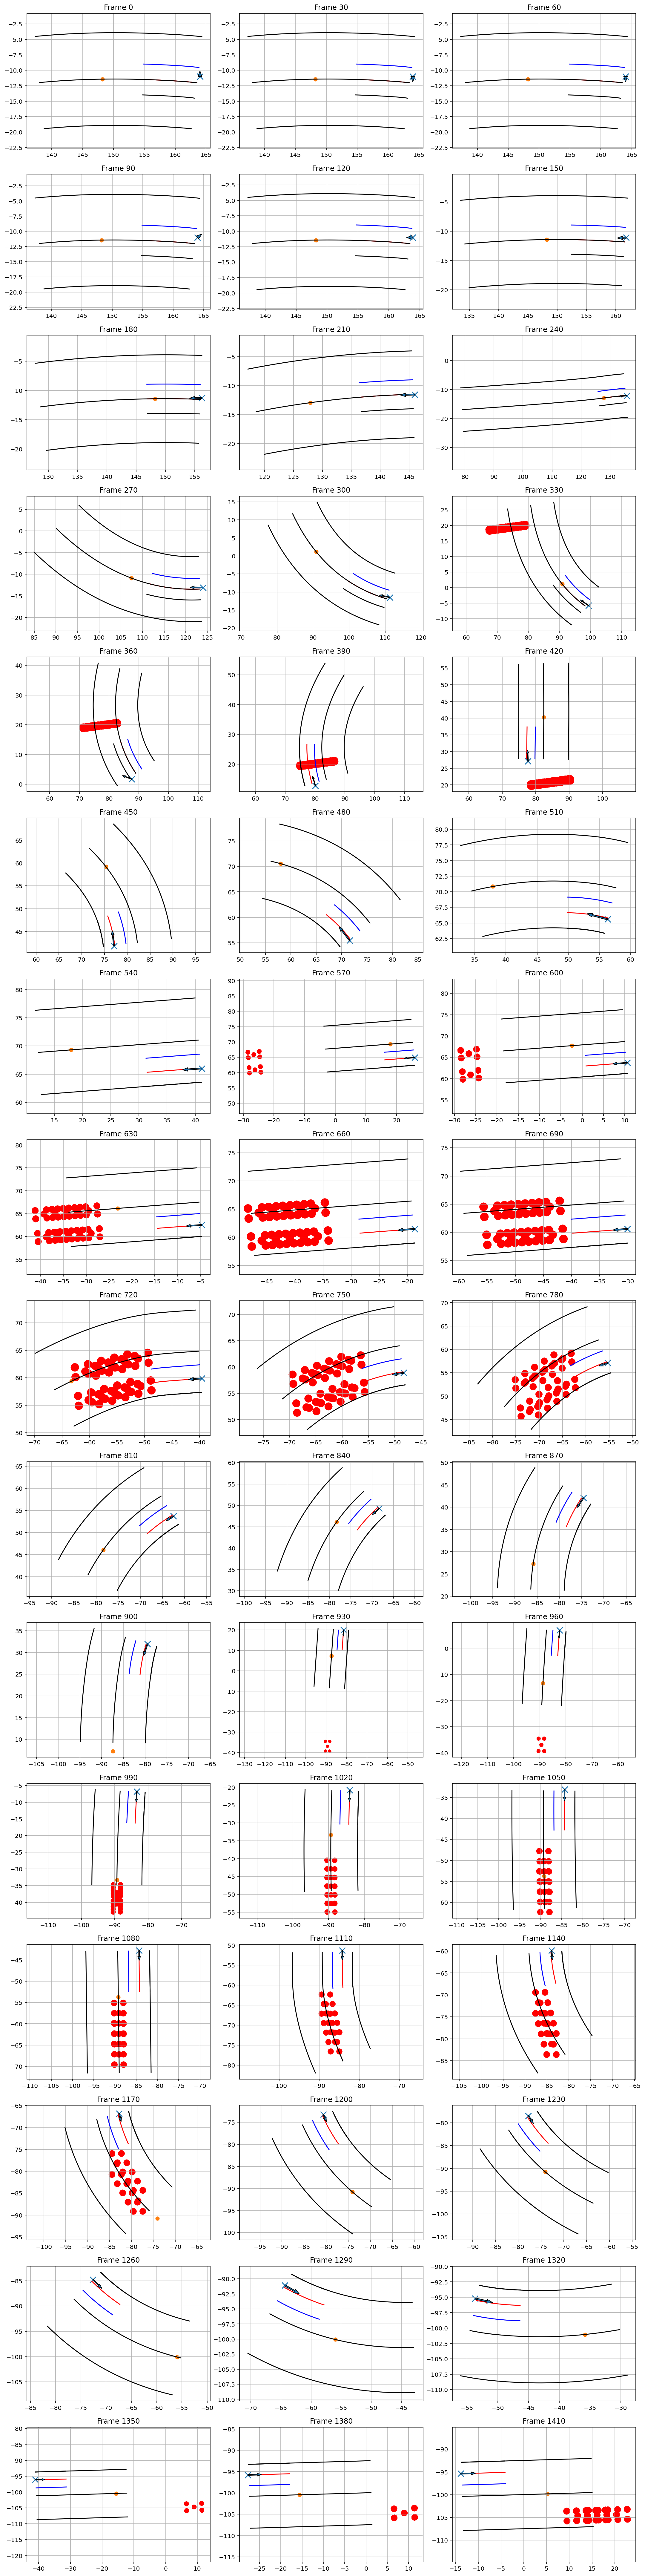

In [6]:
# RRT* decision plot
# adjust your params  here
dec = grrt.RRTStarDecision(
    path_resolution=0.4, 
    expand_dis=0.4, 
    connect_circle_dist=5.0, 
    max_iter=600,
    goal_sample_rate=60.0,
    predictor_steps=3,
    road_subdivisions=7,
    vehicle_radius=1.5,
    lanes_radius=1.5
)
fig, axs = plt.subplots(figsize=(15, 60), ncols=3, nrows=16)



mult = 30 # step multiplier
last_step = 0
for idx, ax in enumerate(axs.flatten()):
    cidx = idx * mult
    for sidx in range(last_step, cidx):
        crecord = traces[sidx]
        cs = CurrentState.from_dict(crecord)
        dec.predictor.submit_obstacles(cs.obstacles)
        #dec.get_path(cs)
    last_step = cidx + 1
    try:
        crecord = traces[cidx]
        cs = CurrentState.from_dict(crecord)
        p, _, _ = dec.get_path(cs)
        r, c, l = get_lanes(cs)
        ax.plot(*np.array(p).T)
    except TypeError:
        pass
    crecord = traces[cidx]
    cs = CurrentState.from_dict(crecord)
    plot_scenario(ax, cs, dec.predictor, dec.vehicle_radius, dec.person_radius, dec.last_state, wp=cs.waypoint, title=f"Frame {idx * mult}{'' if p is not None else ' (STOP)'}")
plt.tight_layout()
plt.savefig("path_plan.pdf")

In [7]:
dec.predictor.get_verts(cs.cpos)

array([[   9.50446705, -105.78238547,    2.5       ],
       [   9.50446705, -105.78238547,    2.5       ],
       [   9.44023804, -103.61989463,    2.5       ],
       [   9.44023804, -103.61989463,    2.5       ],
       [  14.29413513, -105.64012778,    2.5       ],
       [  14.29413513, -105.64012778,    2.5       ],
       [  14.22990612, -103.47763693,    2.5       ],
       [  14.22990612, -103.47763693,    2.5       ],
       [  11.86718658, -104.6300112 ,    2.5       ],
       [  11.63078007, -105.71918789,    2.5       ],
       [  11.63078007, -105.71918789,    2.5       ],
       [  11.56655105, -103.55669705,    2.5       ],
       [  11.56655105, -103.55669705,    2.5       ],
       [  16.42044815, -105.5769302 ,    2.5       ],
       [  16.42044815, -105.5769302 ,    2.5       ],
       [  16.35621914, -103.41443936,    2.5       ],
       [  16.35621914, -103.41443936,    2.5       ],
       [  13.9934996 , -104.56681362,    2.5       ],
       [  13.75709308, -105.

reached max iteration
reached max iteration
reached max iteration
reached max iteration
reached max iteration
